# 📊 Alura Store: Análise Data-Driven para Decisão Estratégica

## 1. 🎯 Contexto do Problema

Nosso desafio é ajudar o **Senhor João** a tomar uma decisão crucial: **qual de suas 4 lojas da Alura Store vender** para iniciar um novo empreendimento. 

**Objetivo Principal:**  
Identificar a loja com o **menor desempenho integrado** considerando:
- 💵 Faturamento e tendências históricas  
- 🌍 Desempenho geográfico  
- 😊 Satisfação do cliente  
- 🚚 Eficiência logística  

**Dados Disponíveis:**  
Vendas de 2020 a 2023, avaliações de clientes e localização das vendas.

### 1.1 🔧 Ferramentas Utilizadas
Para esta análise, montamos nosso *toolkit* estratégico:
- `pandas` para manipulação de dados  
- `seaborn` e `matplotlib` para visualização  
- `folium` para geolocalização  
- `numpy` como auxiliar em algumaas funções

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### 1.2 📥 Importação dos Dados
Trabalharemos com dados históricos de vendas (2021-2023) das 4 lojas, contendo:
- Produtos vendidos  
- Categorias  
- Avaliações  
- Dados geográficos 

In [24]:
# Carregar e consolidar os dados
loja1 = pd.read_csv('data/loja_1.csv')
loja2 = pd.read_csv('data/loja_2.csv')
loja3 = pd.read_csv('data/loja_3.csv')
loja4 = pd.read_csv('data/loja_4.csv')


### 1.3 🧩 Unificação dos Dados
Para otimizar nossa análise, consolidamos todos os dados em um **único DataFrame**, permitindo:
- Comparações diretas entre lojas  
- Código mais limpo e eficiente  
- Análises agregadas

In [38]:
# Adicionando uma coluna 'Loja' em cada data frame
loja1['Loja'] = 'Loja 1'
loja2['Loja'] = 'Loja 2'
loja3['Loja'] = 'Loja 3'
loja4['Loja'] = 'Loja 4'


# Criando o único data frame
lojas = [loja1, loja2, loja3, loja4]

df = pd.concat(lojas, ignore_index=True)

## 2. 🔍 Análise Exploratória (EDA)

### 2.1 💰 Faturamento por Loja
**Primeira métrica crítica:** performance financeira.  

**Descobertas Chave:**  
- Todas as lojas têm faturamento similar  
- Necessidade de analisar tendências temporais  

In [41]:
faturamento = df.groupby('Loja')['Preço'].sum().sort_values(ascending=False).reset_index()

display(faturamento)

,Loja,Preço
0,Loja 1,1534509.12
1,Loja 2,1488459.06
2,Loja 3,1464025.03
3,Loja 4,1384497.58


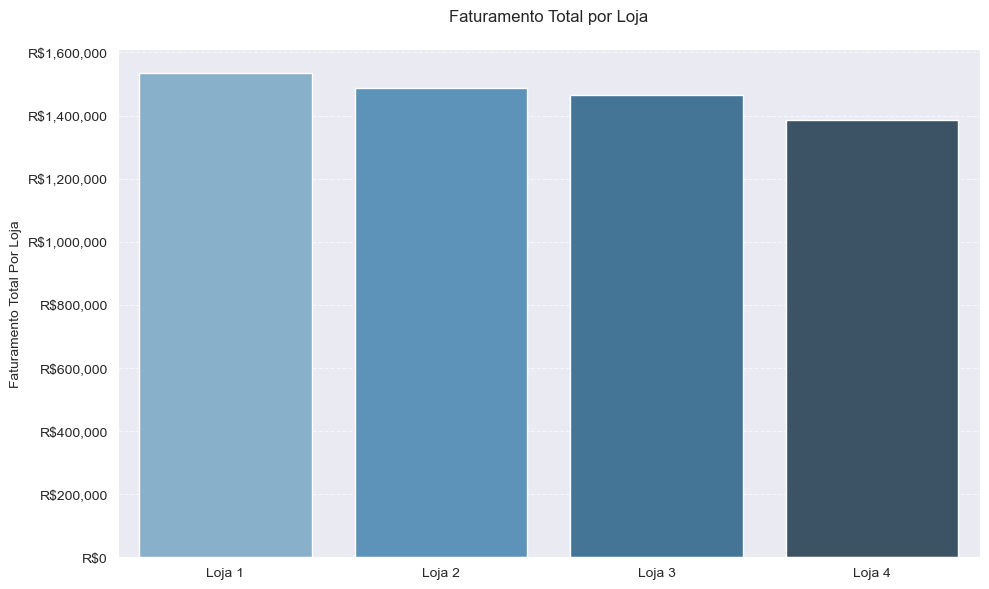

In [27]:
# Plotando o gráfico do faturamento
plt.figure(figsize=(10, 6))
sns.barplot(data=faturamento, x='Loja', y='Preço', hue='Loja', palette='Blues_d', legend=False)
plt.title('Faturamento Total por Loja', pad=20)
plt.ylabel('Faturamento Total Por Loja')
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Análise Temporal Reveladora:**  
Ao examinar os dados anuais (excluindo 2023 incompleto):
- 📉 Loja 1: Queda consistente  
- 📈 Loja 2: Crescimento constante  
- ↔️ Lojas 3 e 4: Variação sem tendência clara  

In [28]:
# Extrair ano da data
df['Ano'] = pd.to_datetime(df['Data da Compra'],  format='%d/%m/%Y').dt.year

# Calcular faturamento anual por loja
faturamento_anual = df.groupby(['Ano', 'Loja'])['Preço'].sum().unstack()
print(faturamento_anual)

Loja     Loja 1     Loja 2     Loja 3     Loja 4
Ano                                             
2020  491911.51  427288.25  428943.09  441129.52
2021  482829.91  468288.89  483938.91  463763.27
2022  422086.24  477635.56  467250.70  402961.23
2023  137681.46  115246.36   83892.33   76643.56


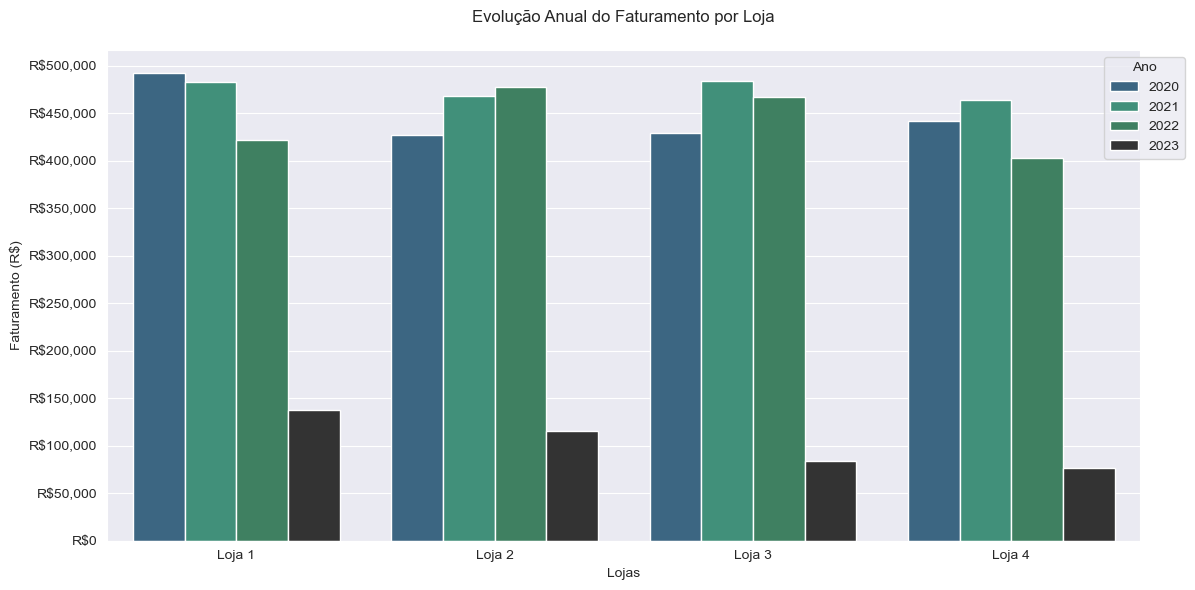

In [29]:
# Plotando gráfico do faturamento anual
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Loja', y='Preço', hue='Ano', estimator=sum,
            palette='viridis_d', errorbar=None)
plt.title('Evolução Anual do Faturamento por Loja', pad=20)
plt.xlabel('Lojas')
plt.ylabel('Faturamento (R$)')
plt.yticks(range(0, 550000, 50000))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### 2.2 🏷️ Desempenho por Categoria
**Padrão Inesperado:** Todas as lojas compartilham as mesmas categorias líderes:
1. Móveis  
2. Eletrônicos  
3. Brinquedos  

**Implicação:** As categorias **não diferenciam** o desempenho das lojas, exigindo outros critérios de decisão.

In [30]:
# Calcula a quantidade de vendas por categoria em cada loja
vendas_categoria_volume = df.groupby(['Loja', 'Categoria do Produto']).size().reset_index(name='Qtd_Vendas')

# Ordena por loja e quantidade de vendas
vendas_categoria_volume = vendas_categoria_volume.sort_values(['Loja', 'Qtd_Vendas'], ascending=[True, False])

print("Volume de Vendas por Categoria:\n")

lojas = vendas_categoria_volume['Loja'].unique()

for loja in lojas:
    tabela_loja = vendas_categoria_volume[vendas_categoria_volume['Loja'] == loja]
    display(tabela_loja.style.background_gradient(cmap='Greens', subset=['Qtd_Vendas']))

Volume de Vendas por Categoria:



,Loja,Categoria do Produto,Qtd_Vendas
6,Loja 1,moveis,465
2,Loja 1,eletronicos,448
0,Loja 1,brinquedos,324
1,Loja 1,eletrodomesticos,312
3,Loja 1,esporte e lazer,284
4,Loja 1,instrumentos musicais,182
5,Loja 1,livros,173
7,Loja 1,utilidades domesticas,171


,Loja,Categoria do Produto,Qtd_Vendas
14,Loja 2,moveis,442
10,Loja 2,eletronicos,422
8,Loja 2,brinquedos,313
9,Loja 2,eletrodomesticos,305
11,Loja 2,esporte e lazer,275
12,Loja 2,instrumentos musicais,224
13,Loja 2,livros,197
15,Loja 2,utilidades domesticas,181


,Loja,Categoria do Produto,Qtd_Vendas
22,Loja 3,moveis,499
18,Loja 3,eletronicos,451
16,Loja 3,brinquedos,315
17,Loja 3,eletrodomesticos,278
19,Loja 3,esporte e lazer,277
21,Loja 3,livros,185
20,Loja 3,instrumentos musicais,177
23,Loja 3,utilidades domesticas,177


,Loja,Categoria do Produto,Qtd_Vendas
30,Loja 4,moveis,480
26,Loja 4,eletronicos,451
24,Loja 4,brinquedos,338
27,Loja 4,esporte e lazer,277
25,Loja 4,eletrodomesticos,254
31,Loja 4,utilidades domesticas,201
29,Loja 4,livros,187
28,Loja 4,instrumentos musicais,170


<Figure size 1400x1000 with 0 Axes>

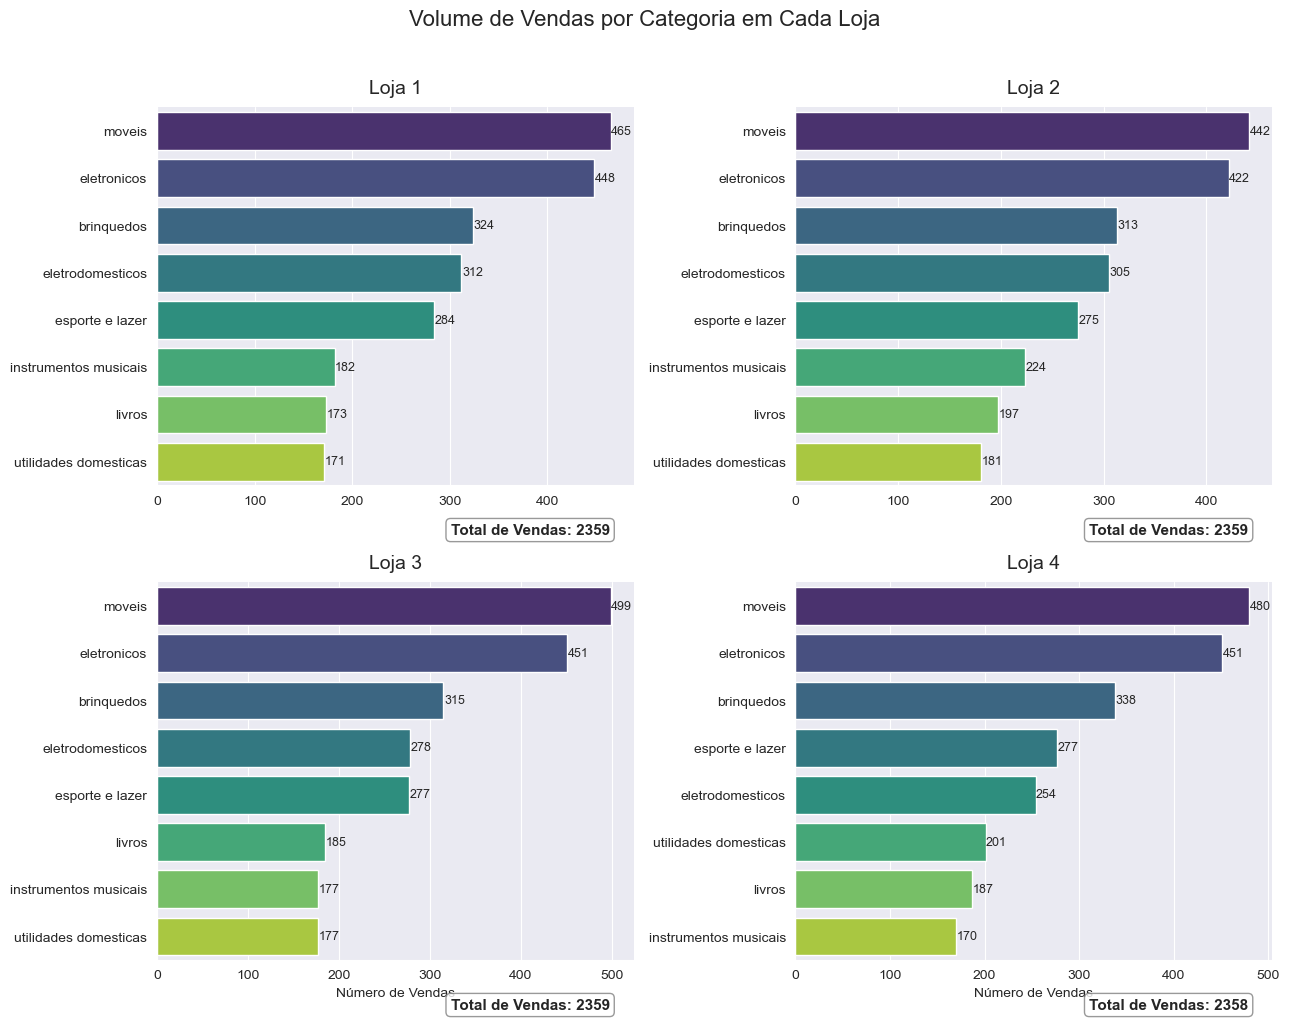

In [31]:
# Criar uma coluna com a ordem de popularidade de categoria para cada loja
vendas_categoria_volume['Rank'] = vendas_categoria_volume.groupby('Loja')['Qtd_Vendas'].rank(ascending=False, method='dense')

# Plot dos gráficos
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(
    vendas_categoria_volume,
    col='Loja',
    col_wrap=2,
    height=5,
    sharex=False,
    sharey=False,
    aspect=1.3
)

# Função para plotar cada subgráfico com ordem própria
# Calcula o total de vendas por loja
totais_por_loja = vendas_categoria_volume.groupby('Loja')['Qtd_Vendas'].sum()

# Função para plotar cada subgráfico com ordenação própria e total
def plot_ordered_bars(data, **kwargs):
    loja = data['Loja'].iloc[0]
    ordered_categories = data.sort_values('Qtd_Vendas', ascending=False)['Categoria do Produto']

    ax = sns.barplot(
        data=data,
        x='Qtd_Vendas',
        y='Categoria do Produto',
        hue='Categoria do Produto',
        legend=False,
        order=ordered_categories,
        palette='viridis',
        **kwargs
    )

    # Adiciona os valores nas barras
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            ax.text(
                width + 0.5,
                p.get_y() + p.get_height()/2.,
                f'{int(width)}',
                ha='left',
                va='center',
                fontsize=9
            )

    # Adiciona a legenda com o total de vendas da loja no canto superior direito
    total_vendas = totais_por_loja[loja]
    ax.text(
        0.95, -0.1,
        f'Total de Vendas: {int(total_vendas)}',
        transform=ax.transAxes,
        fontsize=11,
        fontweight='bold',
        ha='right',
        va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8)
    )

# Aplicar a função personalizada
g.map_dataframe(plot_ordered_bars)

# Configurações estéticas
g.set_titles('{col_name}', size=14, pad=10)
g.set_axis_labels('Número de Vendas', '')
g.fig.suptitle('Volume de Vendas por Categoria em Cada Loja', y=1.02, size=16)
plt.tight_layout()
plt.show()

### 2.3 😊 Satisfação do Cliente
**Métrica Crucial:** Avaliações revelam a saúde do relacionamento com clientes.

**Insights:**  
- Loja 1 tem maior taxa de avaliações ruins (1-2 estrelas)  
- Todas as lojas têm >50% avaliações máximas (5 estrelas)  
- Média < Mediana: Viés para avaliações altas  

**Próximo Passo:** Investigar quais categorias geram más avaliações.

In [32]:
# Calculando todas as métricas de uma vez
estatisticas_avaliacao = df.groupby('Loja')['Avaliação da compra'].agg(
    Média='mean',
    Mediana='median',
    Moda=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
).sort_values('Média', ascending=False)


print("Estatísticas de Avaliação por Loja:")
display(estatisticas_avaliacao.style.background_gradient(cmap='RdYlGn', subset=['Média', 'Mediana', 'Moda']))

Estatísticas de Avaliação por Loja:


,Média,Mediana,Moda
Loja,,,
Loja 3,4.048326,5.000000,5
Loja 2,4.037304,5.000000,5
Loja 4,3.995759,5.000000,5
Loja 1,3.976685,5.000000,5


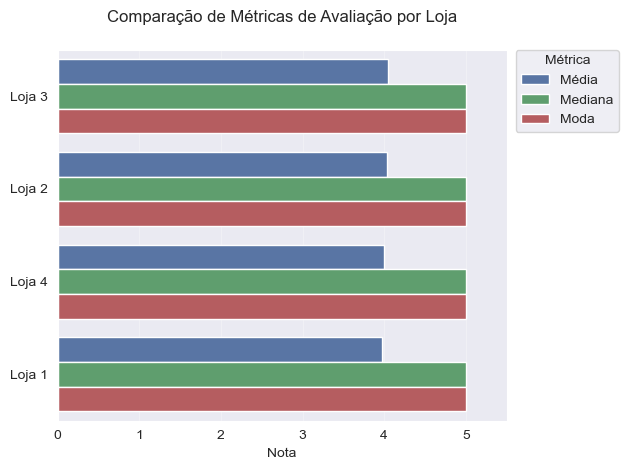

In [33]:
df_melted = estatisticas_avaliacao.reset_index().melt(id_vars='Loja')
df_melted['variable'] = pd.Categorical(df_melted['variable'], categories=['Média', 'Mediana', 'Moda'])

sns.barplot(
    data=df_melted,
    x='value',
    y='Loja',
    hue='variable',
    palette=['#4c72b0', '#55a868', '#c44e52'],
    dodge=True
)

plt.title('Comparação de Métricas de Avaliação por Loja', pad=20)
plt.xlabel('Nota')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 5.5)

# Mover a legenda para fora
plt.legend(
    title='Métrica',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()

Vamos classificar as avaliações da seguinte forma:
 - Ruins (1-2)
 - Médias (3-4) 
 - Boas (5)

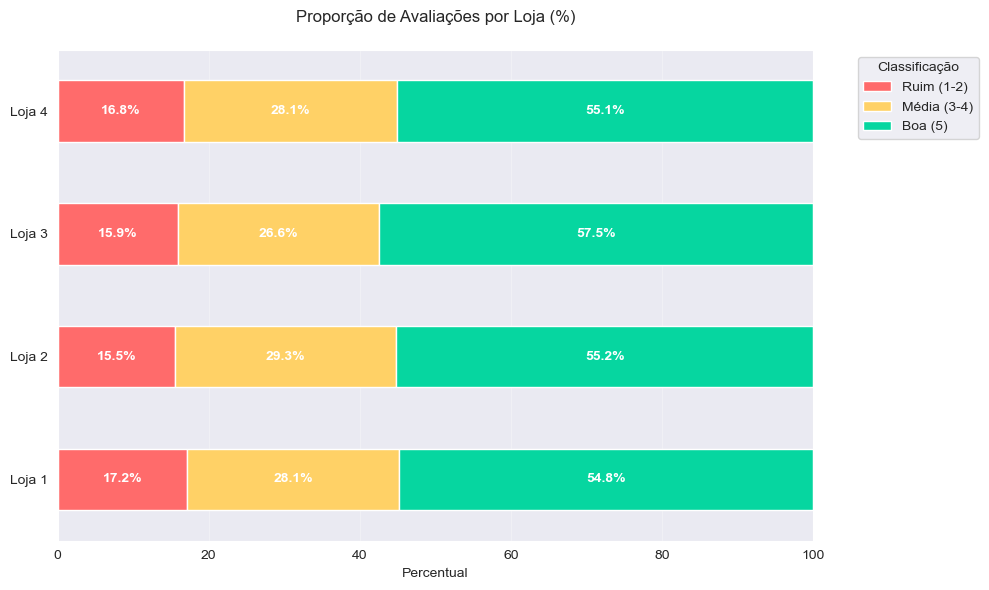

In [34]:
# Criando categorias
df['Classificação'] = pd.cut(
    df['Avaliação da compra'],
    bins=[0, 2, 4, 5],
    labels=['Ruim (1-2)', 'Média (3-4)', 'Boa (5)'],
    right=True
)

# Contagem por classificação
classificacao = df.groupby(['Loja', 'Classificação'], observed=True).size().unstack()

# Convertendo para percentual
classificacao_pct = classificacao.div(classificacao.sum(axis=1), axis=0) * 100

# Plot
ax = classificacao_pct.plot(
    kind='barh',
    stacked=True,
    color=['#ff6b6b', '#ffd166', '#06d6a0'],
    figsize=(10, 6))
plt.title('Proporção de Avaliações por Loja (%)', pad=20)
plt.xlabel('Percentual')
plt.ylabel('')

# Adicionando rótulos
for container in ax.containers:
    ax.bar_label(
        container,
        label_type='center',
        fmt='%.1f%%',
        color='white',
        fontweight='bold'
    )

plt.legend(title='Classificação', bbox_to_anchor=(1.05, 1))
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

### 2.4 🏆 Produtos Mais/Menos Vendidos
**Análise Granular:** Top 3 e Bottom 3 por loja com:
- Volume de vendas  
- Avaliação média  
- Preço médio  

**Padrão Interessante:**  
Produtos menos vendidos frequentemente têm:
- Avaliações mais baixas  
- Maior variação de preço  

In [35]:
def relatorio_produtos(loja_nome):
    # Filtrar dados da loja
    dados_loja = df[df['Loja'] == loja_nome]

    # Top 3 mais vendidos
    top3 = dados_loja.groupby('Produto').agg(
        Vendas=('Produto', 'size'),
        Avaliação_Média=('Avaliação da compra', 'mean'),
        Preço_Médio=('Preço', 'mean')
    ).nlargest(3, 'Vendas')

    # Bottom 3 com pelo menos 1 venda
    bottom3 = dados_loja.groupby('Produto').agg(
        Vendas=('Produto', 'size'),
        Avaliação_Média=('Avaliação da compra', 'mean'),
        Preço_Médio=('Preço', 'mean')
    ).query('Vendas > 0').nsmallest(3, 'Vendas')

    # Concatenar com status
    tabela_final = pd.concat([
        top3.assign(Status='✅ Top 3'),
        bottom3.assign(Status='⚠️ Bottom 3')
    ]).sort_values(by=['Status', 'Vendas'], ascending=[True, False])

    # Renomear colunas para exibição
    tabela_final.columns = ['Vendas', 'Avaliação Média', 'Preço Médio', 'Status']

    # Função para colorir linha por status
    def colorir_status(row):
        if 'Top' in row['Status']:
            return ['background-color: #e6f4ea'] * len(row)
        else:
            return ['background-color: #fff3cd'] * len(row)

    # Estilização
    return (
        tabela_final.style
        .apply(colorir_status, axis=1)
        .background_gradient(cmap='Greens', subset=['Vendas'])
        .background_gradient(cmap='RdYlGn', vmin=1, vmax=5, subset=['Avaliação Média'])
        .format({
            'Avaliação Média': '{:.1f}',
            'Preço Médio': 'R${:,.2f}'
        })
        .set_caption(f'{loja_nome} - Produtos Mais e Menos Vendidos')
    )

# Gerar relatórios para todas as lojas
for loja in df['Loja'].unique():
    display(relatorio_produtos(loja))


,Vendas,Avaliação Média,Preço Médio,Status
Produto,,,,
Panela de pressão,35,3.8,R$100.16,⚠️ Bottom 3
Celular ABXY,33,3.8,"R$1,319.23",⚠️ Bottom 3
Headset,33,4.0,R$191.14,⚠️ Bottom 3
Guarda roupas,60,4.0,R$654.71,✅ Top 3
Micro-ondas,60,4.0,R$772.48,✅ Top 3
TV Led UHD 4K,60,4.0,"R$3,158.90",✅ Top 3


,Vendas,Avaliação Média,Preço Médio,Status
Produto,,,,
Impressora,34,4.4,R$407.26,⚠️ Bottom 3
Mesa de jantar,34,4.2,R$338.71,⚠️ Bottom 3
Jogo de tabuleiro,32,4.0,R$242.17,⚠️ Bottom 3
Iniciando em programação,65,4.0,R$64.15,✅ Top 3
Micro-ondas,62,4.1,R$778.33,✅ Top 3
Bateria,61,4.0,"R$1,009.29",✅ Top 3


,Vendas,Avaliação Média,Preço Médio,Status
Produto,,,,
Jogo de copos,36,4.0,R$44.84,⚠️ Bottom 3
Micro-ondas,36,3.5,R$709.40,⚠️ Bottom 3
Blocos de montar,35,4.3,R$47.14,⚠️ Bottom 3
Kit banquetas,57,4.2,R$390.63,✅ Top 3
Cama king,56,4.0,R$924.64,✅ Top 3
Mesa de jantar,56,4.2,R$341.10,✅ Top 3


,Vendas,Avaliação Média,Preço Médio,Status
Produto,,,,
Violão,37,3.7,R$405.67,⚠️ Bottom 3
Guarda roupas,34,4.2,R$643.98,⚠️ Bottom 3
Guitarra,33,3.8,"R$1,043.35",⚠️ Bottom 3
Cama box,62,4.0,R$708.53,✅ Top 3
Faqueiro,59,4.0,R$59.87,✅ Top 3
Cama king,56,3.9,R$894.16,✅ Top 3


### 2.5 🚚 Impacto do Frete
**Diferencial Competitivo:** Custos logísticos impactam diretamente a lucratividade.

**Destaques:**  
- Loja 1: Frete acima da média  
- Loja 4: Menor custo logístico  
- Correlação com localização geográfica?  

In [36]:
# Cálculo das estatísticas de frete
estatisticas_frete = df.groupby('Loja').agg(
    Frete_Médio=('Frete', 'mean'),
    Frete_Total=('Frete', 'sum'),
).sort_values('Frete_Médio', ascending=False)

# Formatação profissional
(estatisticas_frete.style
 .format({
    'Frete_Médio': 'R${:.2f}',
    'Frete_Total': 'R${:,.2f}',
})
 .background_gradient(cmap='Reds', subset=['Frete_Médio'])
 .set_caption('📦 Frete por Loja')
 )


,Frete_Médio,Frete_Total
Loja,,
Loja 1,R$34.69,"R$81,837.97"
Loja 2,R$33.62,"R$79,314.16"
Loja 3,R$33.07,"R$78,022.66"
Loja 4,R$31.28,"R$73,755.88"


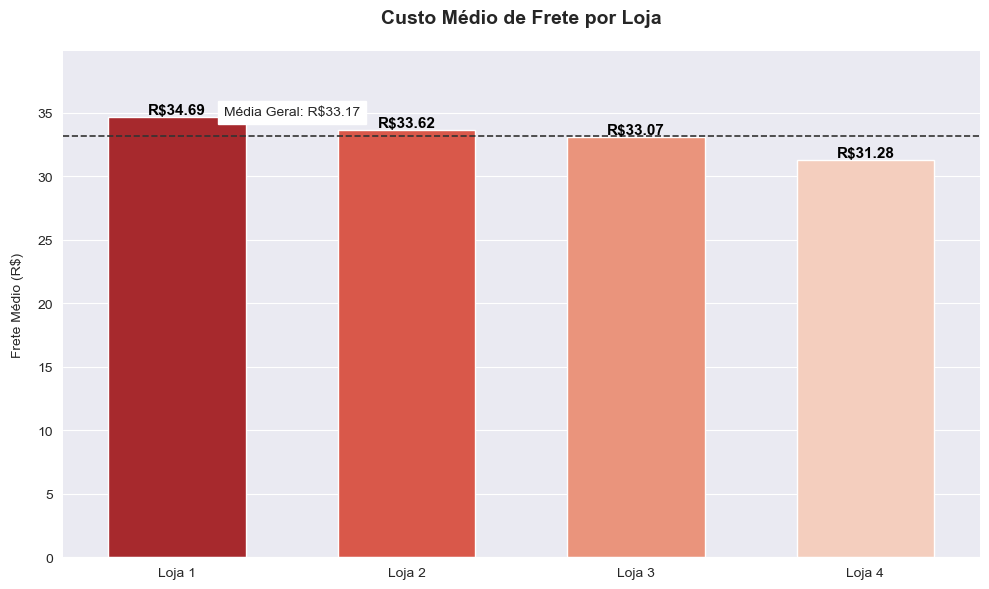

In [37]:
# Criando o gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=estatisticas_frete.reset_index(),
    x='Loja',
    y='Frete_Médio',
    order=estatisticas_frete.sort_values('Frete_Médio', ascending=False).index,
    palette='Reds_r',
    hue='Loja',
    legend=False,
    width=0.6
)

# Personalização
plt.title('Custo Médio de Frete por Loja', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Frete Médio (R$)', labelpad=10)
plt.ylim(0, estatisticas_frete['Frete_Médio'].max() * 1.15)  # Espaço para os rótulos

# Adicionando os valores formatados
for p in ax.patches:
    ax.annotate(
        f'R${p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=11,
        color='black',
        fontweight='bold'
    )

# Linha de referência (média geral)
media_geral = df['Frete'].mean()
ax.axhline(media_geral, color='#333333', linestyle='--', linewidth=1.2)
ax.text(
    x=0.5,
    y=media_geral * 1.05,
    s=f'Média Geral: R${media_geral:.2f}',
    ha='center',
    backgroundcolor='white'
)

# Ajustes finais
sns.despine(left=True)
plt.tight_layout()
plt.show()

## 3. 🌐 Análise Geográfica
**Objetivo:** Entender como a localização afeta:
- Custo de frete  
- Padrões de compra  
- Satisfação regional 

## 4. 🏁 Relatório Final (Em Construção)
Síntese dos critérios para decisão, incluindo:
- Matriz SWOT por loja  
- Recomendação estratégica  
- Próximas ações  